In [1]:
!pip install transformers==3.0.2
!pip install nlp

     |████████████████████████████████| 769 kB 870 kB/s 
     |████████████████████████████████| 3.0 MB 4.1 MB/s 
ERROR: allennlp 1.0.0 has requirement transformers<2.12,>=2.9, but you'll have transformers 3.0.2 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.7.0
    Uninstalling tokenizers-0.7.0:
      Successfully uninstalled tokenizers-0.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.7 MB 881 kB/s 
     |████████████████████████████████| 243 kB 5.1 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import gc
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nlp import load_dataset
from transformers import TFAutoModel, AutoTokenizer

import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(123)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
#MODEL = 'jplu/tf-xlm-roberta-large'
MODEL = 'joeddav/xlm-roberta-large-xnli'

EPOCHS = 4
MAXLEN = 120

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

tokenizer = AutoTokenizer.from_pretrained(MODEL)
auto = tf.data.experimental.AUTOTUNE

In [5]:
def create_model(transformer_layer,learning_rate):
    input_ids = Input(shape = (MAXLEN,), dtype = tf.int32)
    #input_masks = Input(shape = (MAXLEN,), dtype = tf.int32)

    #insert roberta layer
    roberta = TFAutoModel.from_pretrained(transformer_layer)
    roberta = roberta([input_ids])[0]

    out = GlobalAveragePooling1D()(roberta)

    #add our softmax layer
    out = Dense(3, activation = 'softmax')(out)

    #assemble model and compile
    model = Model(inputs = input_ids, outputs = out)
    model.compile(
                    optimizer = Adam(lr = learning_rate), 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])
    return model


def tokeniZer(text,tokenizer):
    # tokenize
    encoded = tokenizer.batch_encode_plus(text, padding=True, max_length=MAXLEN, truncation=True)
    #return np.array(encoded['input_ids'], encoded['attention_mask'])
    return np.array(encoded['input_ids'])

def tokeniZer_old(dataset,tokenizer):
    # tokenize
    text = dataset[['premise', 'hypothesis']].values.tolist()
    encoded = tokenizer.batch_encode_plus(text, padding=True, max_length=MAXLEN, truncation=True)
    # features
    x = encoded['input_ids'], encoded['attention_mask']
    # labels
    y = None
    if 'label' in dataset.columns:
        y = dataset.label.values
    return encoded['input_ids'], encoded['attention_mask'], y


def load_mnli(use_validation=True):
    result = []
    dataset = load_dataset(path='glue', name='mnli')
    print(dataset['train'])
    keys = ['train', 'validation_matched','validation_mismatched'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

def load_snli(use_validation=True):
    result = []
    dataset = load_dataset(path='snli')
    keys = ['train', 'validation'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

def load_xnli():
    result = []
    dataset = load_dataset(path='xnli')
    for k in dataset.keys():
        for record in dataset[k]:
            hp, pr, lb = record['hypothesis'], record['premise'], record['label']
            if hp and pr and lb in {0,1,2}:
                for lang, translation in zip(hp['language'], hp['translation']):
                    pr_lang = pr.get(lang, None)
                    if pr_lang is None:
                        continue
                    result.append((pr_lang, translation, lb,lang))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

In [6]:
# load data
train = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')
submission = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/sample_submission.csv')

In [7]:
train.shape

(12120, 6)

In [8]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [9]:
mnli = load_mnli()

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/637080968c182118f006d3ea39dd9937940e81cfffc8d79836eaae8bba307fc4. Subsequent calls will reuse this data.
Dataset(features: {'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'], names_file=None, id=None), 'idx': Value(dtype='int32', id=None)}, num_rows: 392702)


In [10]:
mnli.shape

(412349, 4)

In [11]:
mnli.head()

,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en


In [12]:
total_train = train.drop(columns=['id'])
total_train = pd.concat([total_train, mnli], axis=0)

shuffled_data = shuffle(total_train).reset_index(drop = True)

X, y = shuffled_data[['premise', 'hypothesis']].values.tolist(), shuffled_data['label']

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2020)

In [14]:
x_train = tokeniZer(x_train,tokenizer)
x_valid = tokeniZer(x_valid,tokenizer)
x_test  = tokeniZer(test[['premise', 'hypothesis']].values.tolist(),tokenizer)

del mnli
gc.collect()

0

In [15]:
# datasets
def build_dataset(x, y, mode, batch_size):
    if mode == "train":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .repeat()
            .shuffle(2048)
            .batch(batch_size)
            .prefetch(auto)
        )
    elif mode == "valid":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(auto)
        )
    elif mode == "test":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices(x)
            .batch(BATCH_SIZE)
        )
    else:
        raise NotImplementedError
    return dataset

In [16]:
train_dataset = build_dataset(x_train, y_train, "train", BATCH_SIZE)
valid_dataset = build_dataset(x_valid, y_valid, "valid", BATCH_SIZE)
test_dataset  = build_dataset(x_test, None, "test", BATCH_SIZE)

In [17]:
def create_xlm(transformer_layer,random_seed,learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    with strategy.scope():
        model = create_model(transformer_layer,learning_rate)
    model.summary()    
    return model

In [18]:
Xlm = create_xlm(MODEL,1124234,1e-5)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 120, 1024), (None 559890432 
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


In [19]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, 
                                              monitor = 'val_loss', 
                                              restore_best_weights = True, 
                                              mode = 'min')]

steps_per_epoch = len(x_train) // BATCH_SIZE
history_xlm = Xlm.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch=steps_per_epoch,
                      epochs = EPOCHS, 
                      callbacks = callbacks)



Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


2487/2487 [==============================] - 879s 353ms/step - accuracy: 0.9197 - loss: 0.2271 - val_accuracy: 0.9352 - val_loss: 0.1869
Epoch 2/4
2487/2487 [==============================] - 822s 331ms/step - accuracy: 0.9408 - loss: 0.1695 - val_accuracy: 0.9333 - val_loss: 0.1969
Epoch 3/4
2487/2487 [==============================] - 852s 342ms/step - accuracy: 0.9564 - loss: 0.1281 - val_accuracy: 0.9284 - val_loss: 0.2211


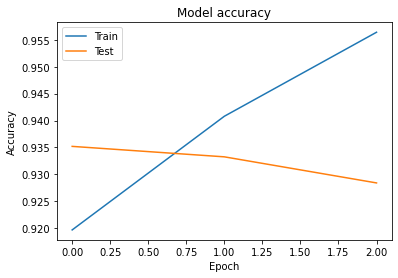

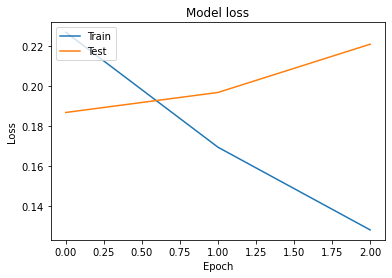

In [20]:
plt.plot(history_xlm.history['accuracy'])
plt.plot(history_xlm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_xlm.history['loss'])
plt.plot(history_xlm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
#model predictions
predictions_xlm = Xlm.predict(test_dataset)
predictions = predictions_xlm
final = np.argmax(predictions, axis = 1)    

submission = pd.DataFrame()    
submission['id'] = test['id']
submission['prediction'] = final.astype(np.int32)

submission.to_csv('submission.csv', index = False)

In [22]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
